In [1]:
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
np.seterr(all='ignore')
import plotly.express as px
import mysql.connector
import psycopg2
pd.options.mode.chained_assignment = None
from IPython.display import display, Markdown, HTML

display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-06-26

In [14]:
mysql_db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

postgres_db = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret')

def query(db, sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

In [10]:
df_raw = pd.read_sql( 
     '''
     select user.username as edit_user, event_log.uuid_id as edit_uuid, event_log.date as edit_date, 
     event_log.event_id as edit_event_id, event_parameter_uuid.uuid_id as content_uuid, 
     content.date as content_date, content.event_id as content_event_id, u.username as content_user
     from event_log 
     join user on user.id = event_log.actor_id
     join event_parameter on event_parameter.log_id = event_log.id
     join event_parameter_uuid on event_parameter.id = event_parameter_uuid.event_parameter_id
     join event_log content on event_parameter_uuid.uuid_id = content.uuid_id
     join user u on content.actor_id = u.id
     where event_log.event_id = 5 and year(event_log.date) > 2018 
     and user.username != "Legacy" and content.event_id = 4
     ''', mysql_db
     )

In [16]:
interest_df = pd.DataFrame(query(postgres_db, "SELECT traits ->> 'username', traits ->> 'interest' FROM identities;"), columns=['username', 'interest'])

In [24]:
df_merged = pd.merge(df_raw, interest_df, left_on="edit_user", right_on="username").rename(columns={'interest': 'edit_user_interest'})
df_merged = pd.merge(df_merged, interest_df, left_on="content_user", right_on="username").rename(columns={'interest': 'content_user_interest'})
df_merged = df_merged.drop(["username_x", "username_y"], axis=1)

In [25]:
df_merged

             edit_user  edit_uuid           edit_date  edit_event_id  \
0                 Leo1     127422 2019-01-02 10:35:03              5   
1                 Leo1     127424 2019-01-02 10:58:42              5   
2                 Leo1     127447 2019-01-02 18:11:50              5   
3                 Leo1     127453 2019-01-03 11:12:16              5   
4                 Leo1     127548 2019-01-04 13:06:10              5   
...                ...        ...                 ...            ...   
82040         testifoo     271418 2023-03-27 18:58:02              5   
82041           Adam09     273789 2023-05-06 13:34:23              5   
82042           Adam09     273790 2023-05-06 13:35:25              5   
82043           Adam09     273791 2023-05-06 13:50:06              5   
82044  sharmajaanvi770     276500 2023-06-09 23:57:14              5   

       content_uuid        content_date  content_event_id     content_user  \
0            127338 2018-12-28 14:03:59                 4

In [26]:
df = df_merged.copy()
df['collaboration'] = np.where(df['edit_user'] == df['content_user'], 'no', 'yes')
df

             edit_user  edit_uuid           edit_date  edit_event_id  \
0                 Leo1     127422 2019-01-02 10:35:03              5   
1                 Leo1     127424 2019-01-02 10:58:42              5   
2                 Leo1     127447 2019-01-02 18:11:50              5   
3                 Leo1     127453 2019-01-03 11:12:16              5   
4                 Leo1     127548 2019-01-04 13:06:10              5   
...                ...        ...                 ...            ...   
82040         testifoo     271418 2023-03-27 18:58:02              5   
82041           Adam09     273789 2023-05-06 13:34:23              5   
82042           Adam09     273790 2023-05-06 13:35:25              5   
82043           Adam09     273791 2023-05-06 13:50:06              5   
82044  sharmajaanvi770     276500 2023-06-09 23:57:14              5   

       content_uuid        content_date  content_event_id     content_user  \
0            127338 2018-12-28 14:03:59                 4

In [27]:
def get_number_of_edits(date, timedelta=90, collaboration="yes"):
    
        df_filtered = df[(df["edit_date"] >= date - pd.Timedelta(days=timedelta)) & (df["edit_date"] <= date)
                        & (df["collaboration"] == collaboration)]
        
        count = df_filtered["edit_event_id"].count()
        
        return count

In [28]:
get_number_of_edits(pd.Timestamp.today(), timedelta=90)

1788

# 1. Plotting

In [29]:
time_index = pd.date_range(start=df["edit_date"].min(), end=df["edit_date"].max(), freq="w")

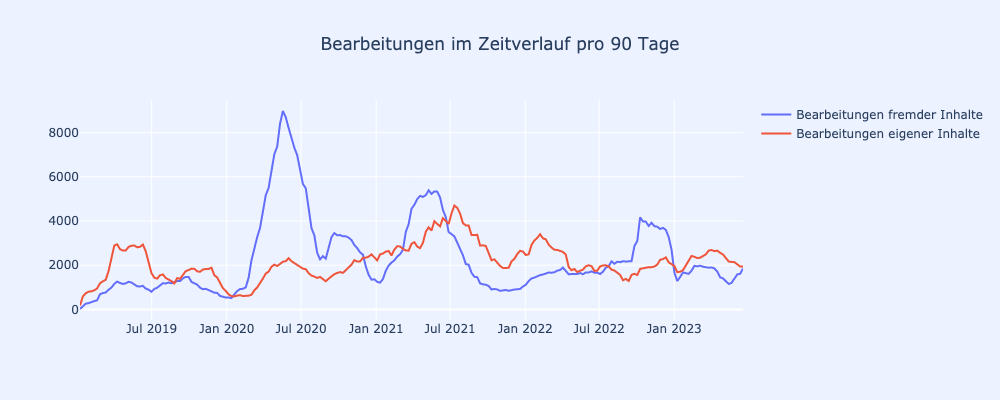

In [30]:


new_labels = {'wide_variable_0':'Bearbeitungen fremder Inhalte', 
              'wide_variable_1': 'Bearbeitungen eigener Inhalte'}

fig = px.line(x=time_index,
                     y= [
                         [get_number_of_edits(date=t) for t in time_index],
                         [get_number_of_edits(date=t, collaboration="no") for t in time_index]
                     ],
                     title="title")
fig.update_layout(title={'text': "Bearbeitungen im Zeitverlauf pro 90 Tage",
                             'x':0.5},
                    plot_bgcolor='#ECF2FF', 
                     paper_bgcolor='#ECF2FF', 
                     height=400, width=1000,
                     legend_title = None,
                    xaxis_title=None,
                     yaxis_title=None)
fig.for_each_trace(lambda t: t.update(name = new_labels[t.name]))

fig.show(renderer="png")